In [0]:
#Imports
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim 
import torch.nn.functional as F
from torchvision import datasets, transforms
import random
from random import shuffle
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from tabulate import tabulate

**Exercise 1. Convolutional Autoencoder.** \\
STEPS:

1. Load MNIST train and test sets. Split the original training data into 95% training and 5% validation data.

2. Implement a convolutional autoencoder (with separate Encoder and Decoder modules).

3. Train the convolutional autoencoder, with different bottleneck sizes. Plot the train and validation loss curves of all autoencoders in the same figure.

4. Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. Show the results in a table, including #params of each model.

5. Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.

6. Generate 5 new images by injecting random values as input to the decoder. Show them.



In [0]:
# Hyper-Parameters Exercise 1.

hparams={
    'batch_size':64,
    'test_batch_size':64,
    'validation_batch_size':64,
    'num_epochs':10,
    'learning_rate':0.5e-3,
    'learning_rate_small':0.5e-4,
    'log_interval':50,
}
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

hparams_architecture={
    'kernel_size_l1':5,
    'kernel_size_l2':5,
    'padding':2,
    'num_filters_l1':40,
    'num_filters_l2':60,
    'stride':2,
}


random_seed= 5
np.random.seed(random_seed)
torch.manual_seed(random_seed)
shuffle_dataset = True

In [0]:
#1. Loading MNIST data set

#This line is used in the lab4, It's normalizing the data to have mean=0 and variance=1

train_set=datasets.MNIST('data',train=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))]),download=True)
test_set=datasets.MNIST('data',train=False,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))]),download=True)

#### Validation split ######

split_p=0.05
split=int(np.floor(split_p*len(train_set))) #Computing the number of elements that has the validation set.

#It is necessary to shuffle the train_set before asign the validation set, other option is to shuffle an array with the indexes vector=(1,...,len(train_set))
#and asign the samples vector_shuffle[split:] to the validation set and the rest to the train_set.

indices = list(range(len(train_set)))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PyTorch data samplers and loaders:
train_subset= torch.utils.data.Subset(train_set, train_indices)
valid_subset = torch.utils.data.Subset(train_set, val_indices)

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=hparams['batch_size'])
validation_loader = torch.utils.data.DataLoader(valid_subset, batch_size=hparams['batch_size'])
test_loader = torch.utils.data.DataLoader(test_set ,batch_size=hparams['test_batch_size'])

In [0]:
#Definition of the ConvBlock, Encoder, Decoder and Autoencoder Classes

class ConvBlock(nn.Module):

  def __init__(self, num_inp_channels, num_out_fmaps, 
               kernel_size, pool_size=2):
    super().__init__()
    # TODO: define the 3 modules needed
    self.conv=nn.Conv2d(num_inp_channels,num_out_fmaps,kernel_size, padding=hparams_architecture['padding'])
    self.relu=nn.ReLU()
    self.maxpool=nn.MaxPool2d(pool_size)
  
  def forward(self, x):
    return self.maxpool(self.relu(self.conv(x)))

###############################################################################

class Encoder(nn.Module):

  def __init__(self, bottleneck):
    super().__init__()

    #Layer (I have read some papers and I think that 2 convolutions + 1 Fully
    #is a good option) 
    
    self.conv1 = ConvBlock(1, hparams_architecture['num_filters_l1'], hparams_architecture['kernel_size_l1'])
    self.conv2 = ConvBlock(hparams_architecture['num_filters_l1'], hparams_architecture['num_filters_l2'], hparams_architecture['kernel_size_l2'])
    
    self.lin=nn.Linear(in_features=((int(28/(hparams_architecture['stride']**2))**2)*hparams_architecture['num_filters_l2']),
                       out_features=bottleneck)

    self.flat=nn.Flatten()

  def forward(self,x):

    x=self.conv1(x)
    x=self.conv2(x)
    x=self.flat(x)
    y=self.lin(x)
    
    return y

#################################################################################
#Check if it is necessary to add padding in the deconvolutions.

class Decoder(nn.Module):
    
  def __init__(self, bottleneck):
    super().__init__()
    
    #Layers

    self.lin=nn.Linear(in_features=bottleneck,
                      out_features=(int(28/(hparams_architecture['stride']**2))**2)*hparams_architecture['num_filters_l2'])  

    self.deconv_l1=nn.ConvTranspose2d(in_channels=hparams_architecture['num_filters_l2'],
                        out_channels=hparams_architecture['num_filters_l1'],
                        kernel_size=hparams_architecture['kernel_size_l2'],
                        stride=hparams_architecture['stride'],
                        padding=hparams_architecture['padding'],
                        output_padding=1)

    self.deconv_l2=nn.ConvTranspose2d(in_channels=hparams_architecture['num_filters_l1'],
                        out_channels=1,
                        kernel_size=hparams_architecture['kernel_size_l1'],
                        stride=hparams_architecture['stride'],
                        padding=hparams_architecture['padding'],
                        output_padding=1)
    
    self.sig=nn.Sigmoid()
    self.relu=nn.ReLU()

  def forward(self,x):
    x=self.lin(x)
    x=self.relu(x)
    x=x.view(-1, hparams_architecture['num_filters_l2'],int(28/4),int(28/4))
    y=self.relu(self.deconv_l2(self.relu(self.deconv_l1(x))))
    return y

###############################################################################

class Autoencoder(nn.Module):
  def __init__(self,bottleneck):
    super().__init__()
    self.encoder = Encoder(bottleneck)
    self.decoder = Decoder(bottleneck)

  def forward(self,x):
    return self.decoder(self.encoder(x))

  def forward_decoder(self,x):
    return self.decoder(x)

# Training process

In [0]:
#Epoch function definition

def train_epoch(train_loader, network, optimizer, criterion, hparams):
  # Activate the train=True flag inside the model
  network.train()
  device = hparams['device']
  avg_loss = None
  avg_weight = 0.1
  for batch_idx, (data,target) in enumerate(train_loader):
      data = data.to(device)      
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, data)
      loss.backward()
      if avg_loss:
        avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
      else:
        avg_loss = loss.item()
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  return avg_loss

In [0]:
def val_epoch(validation_loader, network, hparams, plot_boolean):
    network.eval()
    device = hparams['device']
    validation_loss = 0
    #avg_weight = 0.1
    with torch.no_grad():
        for batch_idx, (data,target) in enumerate(validation_loader):
            data = data.to(device)
            output = network(data)
            validation_loss += criterion(output, data).item() # sum up batch loss
            #if validation_loss:
            #  validation_loss = avg_weight * current_loss.item() + (1 - avg_weight) * validation_loss
            #else:
            #  validation_loss = current_loss.item()

    # Average loss across all correct predictions batches now
    validation_loss /= len(validation_loader)
    if plot_boolean:
      print('\n Validation set: Average loss: {:.4f} \n'.format(validation_loss))
    return validation_loss

Train Epoch: 1 [0/57000 (0%)]	Loss: 1.022768
Train Epoch: 1 [3200/57000 (6%)]	Loss: 0.943327
Train Epoch: 1 [6400/57000 (11%)]	Loss: 0.938489
Train Epoch: 1 [9600/57000 (17%)]	Loss: 0.874101
Train Epoch: 1 [12800/57000 (22%)]	Loss: 0.847866
Train Epoch: 1 [16000/57000 (28%)]	Loss: 0.769928
Train Epoch: 1 [19200/57000 (34%)]	Loss: 0.737975
Train Epoch: 1 [22400/57000 (39%)]	Loss: 0.767525
Train Epoch: 1 [25600/57000 (45%)]	Loss: 0.691424
Train Epoch: 1 [28800/57000 (51%)]	Loss: 0.684525
Train Epoch: 1 [32000/57000 (56%)]	Loss: 0.675605
Train Epoch: 1 [35200/57000 (62%)]	Loss: 0.660115
Train Epoch: 1 [38400/57000 (67%)]	Loss: 0.656344
Train Epoch: 1 [41600/57000 (73%)]	Loss: 0.676117
Train Epoch: 1 [44800/57000 (79%)]	Loss: 0.620886
Train Epoch: 1 [48000/57000 (84%)]	Loss: 0.648126
Train Epoch: 1 [51200/57000 (90%)]	Loss: 0.669574
Train Epoch: 1 [54400/57000 (95%)]	Loss: 0.677431

 Validation set: Average loss: 0.6477 

Train Epoch: 2 [0/57000 (0%)]	Loss: 0.642412
Train Epoch: 2 [3200/57

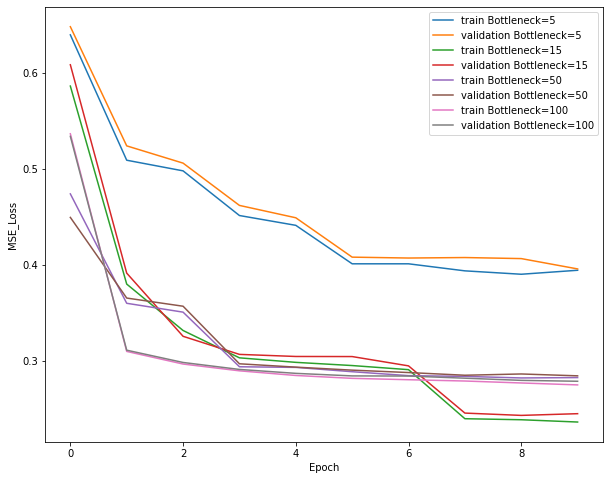

In [0]:
bottleneck_array=[5,15,50,100]

network_array=[]
for i in range(0,len(bottleneck_array)):
  network_array.append(Autoencoder(bottleneck_array[i]))


plt.figure(figsize=(10, 8))

for pos in range(0,len(bottleneck_array)):
    tr_losses = []
    val_losses = []

    bottleneck=bottleneck_array[pos]
    network=network_array[pos]


    network.to(hparams['device'])
    optimizer = optim.RMSprop(network.parameters(), lr=hparams['learning_rate'])
    criterion = F.mse_loss

    for epoch in range(1, hparams['num_epochs'] + 1):
      # Trainig phase
      tr_losses.append(train_epoch(train_loader, network, optimizer, criterion, hparams))
      # Validation phase
      val_loss = val_epoch(validation_loader, network, hparams,True)
      val_losses.append(val_loss)

    plt.xlabel('Epoch')
    plt.ylabel('MSE_Loss')
    plt.plot(tr_losses, label='train Bottleneck='+str(bottleneck))
    plt.plot(val_losses, label='validation Bottleneck='+str(bottleneck))
    plt.legend()

In [0]:
def model_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn 
    return pp

In [0]:
#VALIDATION MSE_error

validation_error=[]
for i in range(0,len(network_array)):
  validation_error.append(val_epoch(validation_loader, network_array[i], hparams,plot_boolean=False))

#TEST MSE_error

test_error=[]
for i in range(0,len(network_array)):
  test_error.append(val_epoch(test_loader, network_array[i], hparams,plot_boolean=False))

#NUMBER OF PARAMETERS
number_param=[]
for i in range(0,len(network_array)):
  number_param.append(model_params(network_array[i]))


header=['Bootleneck Size','Validation error','Test error', 'Number of parameters']  
data=np.array([bottleneck_array,validation_error,test_error,number_param])

print(tabulate(data.transpose(),header))

  Bootleneck Size    Validation error    Test error    Number of parameters
-----------------  ------------------  ------------  ----------------------
                5            0.395677      0.39097                   154486
               15            0.245068      0.242189                  213296
               50            0.284448      0.285201                  419131
              100            0.278797      0.279244                  713181


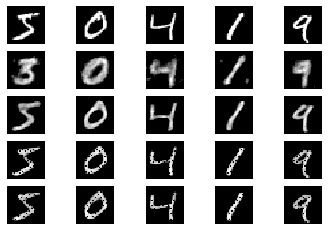

In [0]:
# Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.

N=5
images=train_set.data[0:N]
image=images.view(N,1,28,28)


images_out_set=[]

dtype_t = torch.cuda.FloatTensor
for i in range(0,len(network_array)):
  images_out_set.append(network_array[i](image.cpu().type(dtype_t)).view(-1,28,28).cpu().int())

f,matrix=plt.subplots(len(bottleneck_array)+1, N)

for i in range(0,len(bottleneck_array)+1):
  for j in range(0,N):
    if i==0:
      matrix[i,j].imshow(images[j],cmap='gray')
    else:
      matrix[i,j].imshow(images_out_set[i-1][j],cmap='gray')
    matrix[i,j].axis('off')

#array[0].imshow(image.view(28,28),cmap='gray')
#array[1].imshow(image_out.view(28,28).cpu().int(),cmap='gray')

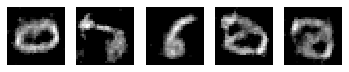

In [0]:
#6. Generate 5 new images by injecting random values as input to the decoder. Show them.

N=5
device=hparams['device']
random_input=torch.randn(N,bottleneck_array[0])*255
random_input=random_input.to(device)

images_art=network_array[0].forward_decoder(random_input)
images_art=images_art.view(-1,28,28)
images_art=images_art.cpu().int()


f,array=plt.subplots(1, N)

for j in range(0,N):
  array[j].imshow(images_art[j],cmap='gray')
  array[j].axis('off')

**Exercise 2. Transfer Learning**

Steps:
1. Select a subset of 100 images and their associated labels from the MNIST training data.

2. Select one of the previously trained autoencoders.

3. Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.

4. Pre-training: use the weights of the autoencoders as initial values for the network weights and train a classification model on the subset of 100 samples.

5. Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.

6. From scratch: train a model on the 100 samples without reusing the decoder weights at all.

7. Show the accuracy of the four models on the MNIST test set in a table.

In [0]:
N=100

list_images = list(range(0, N))
trainset_class = torch.utils.data.Subset(train_set, list_images)

trainloader_class = torch.utils.data.DataLoader(trainset_class, batch_size=10,
                                            shuffle=True)

print("Num of samples: ", len(trainloader_class.dataset))

Num of samples:  100


In [0]:
num_classes = 10
class ClassifierMNIST(nn.Module):

    def __init__(self, bottleneck, encoder):
      super().__init__()
      self.encoder = encoder
      self.lin=nn.Linear(bottleneck, num_classes)
      self.relu = nn.ReLU()
      self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self,x):
      x = self.encoder(x)
      x = self.relu(x)
      x = self.lin(x)
      y = self.logsoftmax(x)
      return y

In [0]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) 
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train_class_epoch(train_loader, network, optimizer1, optimizer2, criterion, hparams):

  network.train()
  
  device = hparams['device']
  avg_loss = None
  avg_weight = 0.1

  # For each batch
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer1.zero_grad()
      optimizer2.zero_grad()
      output = network(data)
      loss = criterion(output, target)
      loss.backward()
      if avg_loss:
        avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
      else:
        avg_loss = loss.item()
      optimizer1.step()
      optimizer2.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  return avg_loss

def val_class_epoch(validation_loader, network, criterion, hparams, type_set):

    # if type_set = True --> validation phase
    # if type_set = False --> testing phase
    network.eval()
    
    device = hparams['device']
    val_loss = 0
    acc = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(validation_loader):
            data, target = data.to(device), target.to(device)
            output = network(data)
            val_loss += criterion(output, target).item()        
            acc += correct_predictions(output, target)
            #print("Batch_idx: ", batch_idx)

    # Average accuracy across all correct predictions batches now
    val_loss /= len(validation_loader)
    val_acc = 100. * acc / len(validation_loader.dataset)

    if type_set:
      print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          val_loss, acc, len(validation_loader.dataset), val_acc,
          ))
    else:
      print('Testing set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          val_loss, acc, len(validation_loader.dataset), val_acc,
          ))
    return val_loss, val_acc

Pre-training:
-------------
Train Epoch: 1 [0/100 (0%)]	Loss: 2.861864
Validation set: Average loss: 2.7453, Accuracy: 222/3000 (7%)

Testing set: Average loss: 2.7718, Accuracy: 769/10000 (8%)

Train Epoch: 2 [0/100 (0%)]	Loss: 2.522536
Validation set: Average loss: 2.6498, Accuracy: 264/3000 (9%)

Testing set: Average loss: 2.6735, Accuracy: 865/10000 (9%)

Train Epoch: 3 [0/100 (0%)]	Loss: 2.338271
Validation set: Average loss: 2.5794, Accuracy: 288/3000 (10%)

Testing set: Average loss: 2.6011, Accuracy: 952/10000 (10%)

Train Epoch: 4 [0/100 (0%)]	Loss: 2.380897
Validation set: Average loss: 2.5221, Accuracy: 312/3000 (10%)

Testing set: Average loss: 2.5422, Accuracy: 1037/10000 (10%)

Train Epoch: 5 [0/100 (0%)]	Loss: 2.314232
Validation set: Average loss: 2.4734, Accuracy: 336/3000 (11%)

Testing set: Average loss: 2.4920, Accuracy: 1120/10000 (11%)

Train Epoch: 6 [0/100 (0%)]	Loss: 2.650221
Validation set: Average loss: 2.4302, Accuracy: 356/3000 (12%)

Testing set: Average l

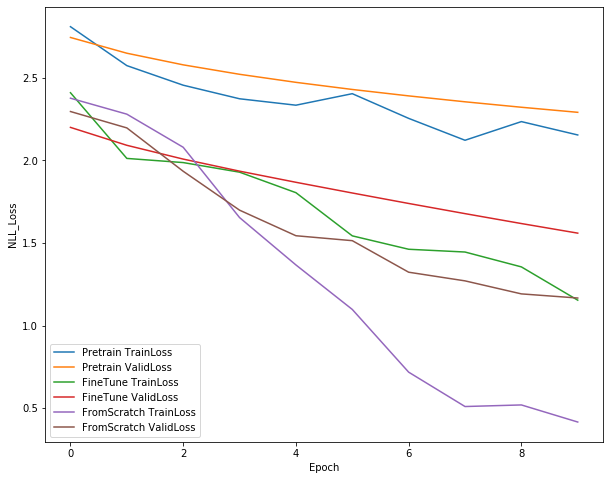

In [0]:
plt.figure(figsize=(10, 8))

# Pre-trained metrics
tr_losses_pt = []
val_losses_pt = []
val_accs_pt = []
test_losses_pt = []
test_accs_pt = []

# Fine-tuned metrics
tr_losses_ft = []
val_losses_ft = []
val_accs_ft = []
test_losses_ft = []
test_accs_ft = []

# From Scratch metrics
tr_losses_fs = []
val_losses_fs = []
val_accs_fs = []
test_losses_fs = []
test_accs_fs = []

selected_bottleneck=1
encoder = network_array[selected_bottleneck].encoder
bottleneck=bottleneck_array[selected_bottleneck]
criterion_class=nn.NLLLoss()

#Pre-training
print("Pre-training:")
print("-------------")
network1=ClassifierMNIST(bottleneck, encoder)
network1.to(hparams['device'])
optimizer1 = optim.RMSprop(network1.lin.parameters(), lr=hparams['learning_rate'])
optimizer2 = optim.RMSprop(network1.encoder.parameters(), lr=0)

for epoch in range(1, hparams['num_epochs'] + 1):
  # Training phase
  tr_losses_pt.append(train_class_epoch(trainloader_class, network1, optimizer1, optimizer2, criterion_class, hparams))
  # Validation phase
  val_loss_class, acc_val = val_class_epoch(validation_loader, network1, criterion_class, hparams, type_set=True)
  val_losses_pt.append(val_loss_class)
  val_accs_pt.append(acc_val)
  # Testing phase
  test_loss_class, acc_test = val_class_epoch(test_loader, network1, criterion_class, hparams, type_set=False)
  test_losses_pt.append(test_loss_class)
  test_accs_pt.append(acc_test)

plt.xlabel('Epoch')
plt.ylabel('NLL_Loss')
plt.plot(tr_losses_pt, label='Pretrain TrainLoss')
plt.plot(val_losses_pt, label='Pretrain ValidLoss')
plt.legend()

#Fine-tuning
print("Fine-tuning:")
print("------------")
network2=ClassifierMNIST(bottleneck, encoder)
network2.to(hparams['device'])
optimizer1 = optim.RMSprop(network2.lin.parameters(), lr=hparams['learning_rate'])
optimizer2 = optim.RMSprop(network2.encoder.parameters(), lr=hparams['learning_rate_small'])

for epoch in range(1, hparams['num_epochs'] + 1):
  # Training phase
  tr_losses_ft.append(train_class_epoch(trainloader_class, network2, optimizer1, optimizer2, criterion_class, hparams))
  # Validation phase
  val_loss_class, acc_val = val_class_epoch(validation_loader, network2, criterion_class, hparams, type_set=True)
  val_losses_ft.append(val_loss_class)
  val_accs_ft.append(acc_val)
  # Testing phase
  test_loss_class, acc_test = val_class_epoch(test_loader, network2, criterion_class, hparams, type_set=False)
  test_losses_ft.append(test_loss_class)
  test_accs_ft.append(acc_test)

plt.xlabel('Epoch')
plt.ylabel('NLL_Loss')
plt.plot(tr_losses_ft, label='FineTune TrainLoss')
plt.plot(val_losses_ft, label='FineTune ValidLoss')
plt.legend()

#From-scratch
print("From-scratch:")
print("-------------")
network3=ClassifierMNIST(bottleneck, Encoder(bottleneck))
network3.to(hparams['device'])
optimizer1 = optim.RMSprop(network3.lin.parameters(), lr=hparams['learning_rate'])
optimizer2 = optim.RMSprop(network3.encoder.parameters(), lr=hparams['learning_rate'])

for epoch in range(1, hparams['num_epochs'] + 1):
  # Training phase
  tr_losses_fs.append(train_class_epoch(trainloader_class, network3, optimizer1, optimizer2, criterion_class, hparams))
  # Validation phase
  val_loss_class, acc_val = val_class_epoch(validation_loader, network3, criterion_class, hparams, type_set=True)
  val_losses_fs.append(val_loss_class)
  val_accs_fs.append(acc_val)
  # Testing phase
  test_loss_class, acc_test = val_class_epoch(test_loader, network3, criterion_class, hparams, type_set=False)
  test_losses_fs.append(test_loss_class)
  test_accs_fs.append(acc_test)

plt.xlabel('Epoch')
plt.ylabel('NLL_Loss')
plt.plot(tr_losses_fs, label='FromScratch TrainLoss')
plt.plot(val_losses_fs, label='FromScratch ValidLoss')
plt.legend()

In [0]:
# Show the accuracy of the four models on the MNIST test set in a table.

models = np.array(["Pre-trained", "Fine-tuned", "From-scratch"])
test_accuracies = np.array([test_accs_pt[len(test_accs_pt)-1], 
                            test_accs_ft[len(test_accs_ft)-1], 
                            test_accs_fs[len(test_accs_fs)-1]])

header=['Model', 'Accuracy']
data=np.array([models,test_accuracies])

print(tabulate(data.transpose(),header))

Model           Accuracy
------------  ----------
Pre-trained        15
Fine-tuned         49.07
From-scratch       66.18


**Exercise 3. Variational Autoencoder**

Steps:

1. Implement an autoencoder like that from Exercise 1, but turning the deterministic bottleneck into a stochastic bottleneck, with an isotropic Gaussian as distribution for the latent variables.

2. Train the model optimizing the Evidence Lower Bound (ELBO).

3. Generate samples with the decoder and show them.

**Exercise 4. Conditional GAN**

Steps:

1. Implement a generator and discriminator based on deconvolutions and convolutions respectively.

2. Train the GAN on MNIST.

3. Generate samples with the generator and show them.